# River bifurcation in CONUS workflow
This notebook contains the workflow necessary to extract data from a HUC4 and join it to NABD for bifurcation analysis.

## 1. Install packages

In [1]:
# import sys
# !{sys.executable} -m pip install geofeather
# !{sys.executable} -m pip install nhdnet  #see Setup info document 

## 2. Load modules

In [2]:
# Basic analysis 
from pathlib import Path
import os
from time import time
import geopandas as gp
import geofeather
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

# Set path
gdrive = Path("/Volumes/GoogleDrive/My Drive/Condon_Research_Group/Research_Projects/Rachel/Research/GIS/Layers") # where shapefiles live on the Drive

## 3. Read in the sample geodatabase

### 3.1 Read in the HUC4 shapefile (1019) I made 

In [3]:
## larger dataset
# flowlines_test = gp.read_file(gdrive/"HUC_test/Test1029.shp")       # this is actually HUC 1019

## subset of above data
flowlines_test = pd.read_csv(gdrive/"NHDPlusNationalData/small1019.csv")

flowlines_test = flowlines_test.rename(columns={"REACHCODE": "Reachcode"})  # rename columns  
flowlines_test = flowlines_test.rename(columns={"StreamOrde": "streamorder"})
# print(flowlines_test)
# list(flowlines_test.columns)

### 3.2 Checks and cleanup of 'flowlines_test'

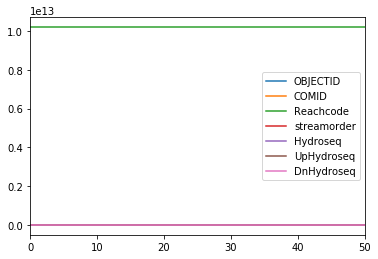

In [4]:
# Checking flowlines
# flowlines_test.head(3)            # see the first 3 rows
# type(flowlines_test.streamorder)  # check data type
# print(len(flowlines_test))        # check length
# set(flowlines_test.streamorder)   # list unique streamorder values

# Cleanup columns
# imp_cols2 = ['OBJECTID', 'COMID', 'Reachcode', 'streamorder', 'geometry', 'Hydroseq', 'UpHydroseq', 'DnHydroseq']  # specify columns we want to keep
imp_cols2 = ['OBJECTID', 'COMID', 'Reachcode', 'streamorder', 'WKT', 'Hydroseq', 'UpHydroseq', 'DnHydroseq'] # for subset
flowlines_test = flowlines_test[imp_cols2]  # filter dataframe with specified columns
# print(flowlines_test)

# Plotting
flowlines_test[flowlines_test.streamorder>0].plot()  # Plot all stream lines

## 4. Join the two datasets (NHD and NABD)
Check [this link](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely/) out for help: 

See also: https://geopandas.org/mergingdata.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

### 4.1 Read NABD and plot

In [5]:
# Read in NABD shapefile
nabd = gp.read_file(gdrive/"nabd_fish_barriers_2012.shp")  # read in NABD from Drive
imp_cols3 = ['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']  # specify columns we want to keep
nabd = nabd[imp_cols3]  # filter dataframe with specified columns
print(list(nabd.columns))
# print(len(nabd))

['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']


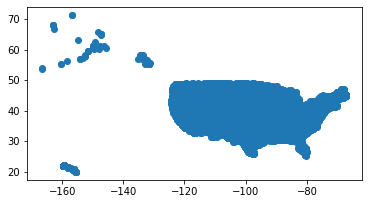

In [6]:
# Plotting check
nabd[nabd.COMID>0].plot()  # plot all dams in US

### 4.2 Merge datasets by COMID

In [7]:
# Merge NABD and NHD
nabd_nhd_join = nabd.merge(flowlines_test, how= 'right', on='COMID')  # how = 'right': merge is done by adding NABD attributes to NHD flowlines based on COMID
                                                                 # the result will have the same length as "flowlines_test"

### 4.3 Checks of 'nabd_nhd_join'

In [8]:
# Checking stuff after merge
# nabd_nhd_join.head(10)  
# nabd_nhd_join.columns
# set(nabd_nhd_join.NIDID)
# type(nabd_nhd_join)
print(len(nabd_nhd_join))  #check the merge
# print(type(nabd_nhd_join))
# print(nabd_nhd_join[nabd_nhd_join.NIDID!='NaN'])

# Plotting  *currently not working, but does not matter*

# nabd_nhd_join[nabd_nhd_join.COMID>0].plot()
# nabd_nhd_join[nabd_nhd_join.streamorder>0].plot(subplots=FALSE)

# item = nabd_nhd_join.NIDID
# colors = []
# for i in nabd_nhd_join.NIDID:
#     if np.isnan(nabd_nhd_join.NIDID[i]) == 'TRUE':
#         colors.append('r')
#     else:
#         colors.append('b')
# plt.plot(x, y)                      
# ax.bar(x, data, color=colors)
# nabd_nhd_join[nabd_nhd_join.NIDID].plot(color=colors)
# set(colors)

51


## 5. How to read in NHDFlowline csv
Exported the Flowline_Network feature class in the NHDPlusV21_National_Seamless_Flattened_Lower48 geodatabase to a csv. [This link](https://gis.stackexchange.com/questions/23376/how-to-export-polygons-to-csv-with-coordinates) helped me keep the geometry of the flowlines

In [9]:
# Flowline csv
# nhdflowlines = pd.read_csv(gdrive/"NHDPlusNationalData/NHDFlowlines.csv")
# nhdflowlines.head(3)

### 5.1 Checking and filtering the csv

In [10]:
# list(flowlines.columns)
# keep_cols = ['OBJECTID', 'COMID', 'REACHCODE', 'StreamOrde', 'WKT', 'Hydroseq', 'UpHydroseq', 'DnHydroseq']  # specify columns we want to keep
# nhdflowlines = nhdflowlines[keep_cols] # filter dataframe with specified columns
# nhdflowlines.head(3)
# nhdflowlines['REACHCODE']
# nhdflowlines['WKT']

### 5.2 Mess around with sample NHD

In [11]:
nhd_sample = pd.read_csv(gdrive/"NHDPlusNationalData/nhd_sample.csv")
# print(nhd_sample)

## 6. Bifurcation calculations
Looking at 'stats.py'

In [12]:
nabd_nhd_join.head(3)
# set(nabd_nhd_join.DnHydroseq)
# x = nabd_nhd_join[nabd_nhd_join.DnHydroseq == '']
# print(x)

## need to add "kind" to the df - See stats.py and Rachel_workflow
nabd_nhd_join.loc[nabd_nhd_join.UpHydroseq > 0, 'kind'] = 'internal'   # there is stream lines above and below this flowline
nabd_nhd_join.loc[nabd_nhd_join.UpHydroseq == 0, 'kind'] = 'origin'    # there is no stream line above this flowline
nabd_nhd_join.loc[nabd_nhd_join.DnHydroseq == 0, 'kind'] = 'terminal'  # there is no stream line below this flowline
# print(nabd_nhd_join.head(3))
set(nabd_nhd_join.kind)

{'internal', 'origin'}

In [17]:
# create series of networkID indexed by COMID?
networkID = nabd_nhd_join
# print(networkID)

list(nabd_nhd_join.columns)
# list(networkID.columns)
# identify all barriers that are upstream of a given network by joining on their downstream Hydroseq (DnHydroseq)
barriers_upstream = (nabd_nhd_join[["UpHydroseq", "kind"]].merge(networkID, on = 'UpHydroseq')
                     .reset_index()[["Hydroseq"]].dropna())
barriers_upstream.Hydroseq = barriers_upstream.Hydroseq.astype("uint32")
# print(barriers_upstream)
len(barriers_upstream)

# # # have to readd column for kind
# # kind = np.zeros(26358)  # for HUC 1019
# kind = np.zeros(73)  # for subset of HUC 1019

# barriers_upstream['kind'] = kind
# # Count barriers that have a given network DOWNSTREAM of them  * do they mean upstream?
# upstream_counts = (barriers_upstream.groupby(["Hydroseq", 'kind']).size().rename("count").reset_index()
#                    .pivot(index="Hydroseq", columns='kind', values="count").rename(columns={
#                 "dam": "up_ndams"}))
# upstream_counts.head(10)
# # print(upstream_counts.columns)

183